In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetSimCLR(nn.Module):

    def __init__(self, device="cpu", embedding_dim=64):
        super(ResNetSimCLR, self).__init__()
        # The embedding_dim is the dimension of the final output dimension
        self.embedding_dim = embedding_dim
        # initiate the resnet backbone
        self.model = models.resnet50(weights=None)
        # dimension of the final CNN layer in resnet (2048 normally)
        self.dim_mlp = self.model.fc.in_features
        # FC network with one hidden layer added on top of the ResNet
        self.model.fc = torch.nn.Sequential(torch.nn.Linear(self.dim_mlp, self.dim_mlp),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(self.dim_mlp, self.embedding_dim),
                                       torch.nn.ReLU())

    def forward(self, x):
        return self.model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNetSimCLR(device)

In [2]:
model

ResNetSimCLR(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

MEAN=[0.4914, 0.4822, 0.4465]
STD=[0.2470, 0.2435, 0.2616]

img_size = 32
batch_size = 32
root_folder = "./dataset/data"

# trasnformations for the dataset
transform = transforms.Compose([
                transforms.RandomResizedCrop(img_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

# initiate the dataset
dataset = CIFAR10(root=root_folder, train=True, download=True, transform=transform)
#select 1000 sample
subset_indices = list(range(1000))
small_dataset = torch.utils.data.Subset(dataset, subset_indices)
# batching of the dataset
data_loader = DataLoader(small_dataset, batch_size=batch_size, shuffle=True)
# initiate the validation dataset
dataset_val = CIFAR10(root=root_folder, train=False, download=True, transform=transform)
#select 200 validation sample
subset_indices_val = list(range(200))
small_dataset_val = torch.utils.data.Subset(dataset_val, subset_indices_val)
# DataLoader for batching
data_loader_val = DataLoader(small_dataset_val, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from dataset import preprocess_for_train

In [ ]:
from tqdm import tqdm
import numpy as np

def train_one_epoch(model, dataloader, device, img_size, normalizer, criterion, optimizer, epoch, tracker, scheduler = None):
    """
    Trains the model for one epoch using contrastive learning with data augmentation.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        dataloader (torch.utils.data.DataLoader): Dataloader providing batches of input images.
        device (str): The device to run the training on ('cuda' or 'cpu').
        img_size (int): The height and width to which input images should be resized.
        normalizer (callable): Function used to normalize the feature representations.
        criterion (torch.nn.Module): Loss function for contrastive learning.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        epoch (int): Current epoch number.
        tracker (dict): Dictionary to store loss and learning rate per epoch.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Defaults to None.

    Returns:
        list: A list of loss values recorded for each batch during the epoch.

    Notes:
        - Each image in the batch undergoes two different stochastic augmentations.
        - The augmented images are passed through the model to obtain feature representations.
        - The loss is computed using the contrastive loss function (`criterion`).
        - If a learning rate scheduler is provided, it is stepped after the epoch.
        - The tracker dictionary is updated with the epoch's average loss and learning rate.
        - GPU memory is cleared after each epoch if using CUDA.
    """
    # put model in train mode to allow BN update its parameters
    model.train()
    losses = []
    for mini_batch in tqdm(dataloader):
        mini_batch = mini_batch[0].to(device)
        augmented_batch = []  # To store 2N images
        for image in mini_batch:
            # creating the augmentations
            augmented_1 = preprocess_for_train(image, height=img_size, width=img_size, color_distort=True, crop=True, flip=True)
            augmented_2 = preprocess_for_train(image, height=img_size, width=img_size, color_distort=True, crop=True, flip=True)
            augmented_batch.extend([augmented_1, augmented_2])

        augmented_batch = torch.stack(augmented_batch)  # Shape: [2N, C, H, W]
        representations = model(augmented_batch.permute(0,3,1,2))
        projections = normalizer(representations, dim=1)
        loss = criterion(projections)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
    if scheduler:
        scheduler.step()

    tracker[epoch+1] = {"Loss": np.mean(losses), "lr": optimizer.param_groups[0]['lr']}
    print(f"Epoch {epoch+1}, Loss: {np.mean(losses)}, lr: {optimizer.param_groups[0]['lr']}")

    # Clear GPU memory
    del mini_batch, augmented_batch, representations, projections, loss
    if device == "cuda":
        torch.cuda.empty_cache()

    return losses

In [ ]:
from copy import deepcopy

def eval(dataloader_val, model, device, normalizer, criterion, epoch, tracker, img_size):
    """
    Evaluates the model on the validation dataset using contrastive learning.

    Args:
        dataloader_val (torch.utils.data.DataLoader): Dataloader providing batches of validation images.
        model (torch.nn.Module): The trained neural network model to be evaluated.
        device (str): The device to run evaluation on ('cuda' or 'cpu').
        normalizer (callable): Function used to normalize the feature representations.
        criterion (torch.nn.Module): Loss function for contrastive learning.
        epoch (int): Current epoch number.
        tracker (dict): Dictionary to store validation loss for each epoch.
        img_size (int): The height and width to which input images should be resized.

    Returns:
        list: A list of validation loss values recorded for each batch.

    Notes:
        - The model is deep-copied and set to evaluation mode to prevent training updates.
        - Each image in the batch undergoes two different stochastic augmentations.
        - The augmented images are processed by the model to obtain feature representations.
        - The loss is computed using the contrastive loss function (`criterion`).
        - The tracker dictionary is updated with the validation loss for the current epoch.
        - GPU memory is cleared after each batch if CUDA is used to prevent memory overflow.
    """
    eval_model = deepcopy(model)
    eval_model.eval()
    val_losses = []
    with torch.no_grad():
        for mini_batch in tqdm(dataloader_val, desc="Evaluating"):
            mini_batch = mini_batch[0].to(device)
            augmented_batch = []
            for image in mini_batch:
                augmented_1 = preprocess_for_train(image, height=img_size, width=img_size, color_distort=True, crop=True, flip=True)
                augmented_2 = preprocess_for_train(image, height=img_size, width=img_size, color_distort=True, crop=True, flip=True)
                augmented_batch.extend([augmented_1, augmented_2])
            augmented_batch = torch.stack(augmented_batch)
            representations = eval_model(augmented_batch.permute(0, 3, 1, 2))
            projections = normalizer(representations, dim=1)
            loss = criterion(projections)
            val_losses.append(loss.item())
            # Clear GPU memory for each batch
            del mini_batch, augmented_batch, representations, projections, loss
            if device == "cuda":
                torch.cuda.empty_cache()
    avg_loss = np.mean(val_losses)
    tracker[epoch+1]["Loss_val"] = avg_loss
    print(f"Epoch {epoch+1}, Validation Loss: {avg_loss:.4f}")
    del eval_model
    return val_losses

In [7]:
import json
import os

def save_checkpoint(model, optimizer, scheduler, total_loss, epoch, checkpoint_dir):
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
        "total_loss": total_loss,
    }
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pt")
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

In [8]:
from torch.nn.functional import cross_entropy

def l2_normalize(tensor, dim=1, epsilon=1e-12):
    """
    Performs L2 normalization on the given tensor along the specified dimension.
    
    Args:
        tensor (torch.Tensor): The input tensor to normalize.
        dim (int): The dimension along which to normalize (default: 1).
        epsilon (float): Small constant to avoid division by zero (default: 1e-12).
    
    Returns:
        torch.Tensor: L2-normalized tensor.
    """
    norm = torch.sqrt(torch.sum(tensor**2, dim=dim, keepdim=True) + epsilon)
    return tensor / norm

def contrastive_loss(projections, temperature=0.1):
    """
    Compute NT-Xent loss for contrastive learning.
    
    Args:
        projections (torch.Tensor): Tensor of shape [2N, d], where 2N is the batch size
                                    (N samples with two augmented views each) and d is
                                    the feature dimension.
        temperature (float): Temperature scaling parameter for the loss.
    
    Returns:
        torch.Tensor: Scalar loss value.
    """
    # Normalize projections to unit vectors
    # projections = F.normalize(projections, dim=1)

    # Compute similarity matrix (cosine similarity)
    similarity_matrix = torch.matmul(projections, projections.T)  # Shape: [2N, 2N]
    
    # Scale by temperature
    similarity_matrix = similarity_matrix / temperature

    # Create labels for positive pairs
    N = projections.size(0) // 2  # Number of original samples
    labels = torch.add(torch.arange(2*N, device=projections.device), torch.tensor([1, -1], device=projections.device).repeat(N))

    # Mask out self-similarities
    mask = torch.eye(2 * N, device=projections.device).bool()
    similarity_matrix.masked_fill_(mask, float('-inf'))

    # Compute loss using cross-entropy
    loss = cross_entropy(similarity_matrix, labels)
    return loss

In [9]:
from torch.optim.lr_scheduler import StepLR

lr=0.01
weight_decay=0.0001
gamma=0.5
step_size = 40

normalizer = l2_normalize
criterion = contrastive_loss

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

tracker = {}

def train(model = model, dataloader = data_loader, dataloader_val = data_loader_val, device = "cpu", 
          img_size = img_size, normalizer = normalizer, criterion = criterion, optimizer = optimizer,
          tracker = tracker, scheduler = scheduler, num_epochs = 100, validationstep = 10,
          save_checkpoints = 10, checkpoint_dir = "checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    model.to(device)
    total_loss = []
    total_eval_loss = []
    for epoch in range(num_epochs):
        losses = train_one_epoch(model, dataloader, device, img_size, normalizer, criterion, optimizer, epoch, tracker, scheduler)
        total_loss.extend(losses)
        if (epoch+1)%validationstep == 0:
            eval_loss = eval(dataloader_val, model, device, normalizer, criterion, epoch, tracker, img_size)
            total_eval_loss.extend(list(eval_loss))
        if (epoch+1)%save_checkpoints == 0:
            save_checkpoint(model, optimizer, scheduler, total_loss, epoch, checkpoint_dir)
        if device == "cuda":
            torch.cuda.empty_cache()
    
    tracker_path = os.path.join(checkpoint_dir, "tracker.json")
    with open(tracker_path, "w") as f:
        json.dump(tracker, f)
    print(f"Tracker saved to {tracker_path}")

In [10]:
train(device = "cuda")

100%|██████████| 32/32 [00:03<00:00,  9.52it/s]


Epoch 1, Loss: 3.967508904635906, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 2, Loss: 3.8524583876132965, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 3, Loss: 3.7520804703235626, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 4, Loss: 3.5485880598425865, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 5, Loss: 3.4310799315571785, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 6, Loss: 3.3271264135837555, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 7, Loss: 3.1979636549949646, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 8, Loss: 3.1161052621901035, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 9, Loss: 2.966110125184059, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.74it/s]


Epoch 10, Loss: 2.850347263738513, lr: 0.01


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.82it/s]


Epoch 10, Validation Loss: 3.0054
Checkpoint saved: checkpoints/checkpoint_epoch_10.pt


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 11, Loss: 2.9885375425219536, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 12, Loss: 2.9870755821466446, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 13, Loss: 2.9647104889154434, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.70it/s]


Epoch 14, Loss: 2.904036559164524, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 15, Loss: 2.94562578946352, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.70it/s]


Epoch 16, Loss: 2.788046732544899, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 17, Loss: 2.7241088524460793, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 18, Loss: 2.8253625482320786, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 19, Loss: 2.616648182272911, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.79it/s]


Epoch 20, Loss: 2.6255067884922028, lr: 0.01


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.80it/s]


Epoch 20, Validation Loss: 2.8153
Checkpoint saved: checkpoints/checkpoint_epoch_20.pt


100%|██████████| 32/32 [00:02<00:00, 10.84it/s]


Epoch 21, Loss: 2.747528310865164, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.86it/s]


Epoch 22, Loss: 2.7345632016658783, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 23, Loss: 2.690097466111183, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.86it/s]


Epoch 24, Loss: 2.386316319927573, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.86it/s]


Epoch 25, Loss: 2.259243751876056, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 26, Loss: 2.074266125448048, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 27, Loss: 1.9105293485336006, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.86it/s]


Epoch 28, Loss: 1.8474419182166457, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 29, Loss: 1.8435276302043349, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 30, Loss: 1.680473864544183, lr: 0.01


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.81it/s]


Epoch 30, Validation Loss: 2.7708
Checkpoint saved: checkpoints/checkpoint_epoch_30.pt


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 31, Loss: 2.670218087732792, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 32, Loss: 2.667660638689995, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 33, Loss: 2.597170192748308, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.84it/s]


Epoch 34, Loss: 2.5607010796666145, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 35, Loss: 2.638604450970888, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 36, Loss: 2.3447534274309874, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.86it/s]


Epoch 37, Loss: 2.3250912949442863, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.86it/s]


Epoch 38, Loss: 2.4228835683315992, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.84it/s]


Epoch 39, Loss: 2.1679595597088337, lr: 0.01


100%|██████████| 32/32 [00:02<00:00, 10.84it/s]


Epoch 40, Loss: 2.1646836325526237, lr: 0.005


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.81it/s]


Epoch 40, Validation Loss: 2.4630
Checkpoint saved: checkpoints/checkpoint_epoch_40.pt


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 41, Loss: 2.561576507985592, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 42, Loss: 2.537856187671423, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.84it/s]


Epoch 43, Loss: 2.1396084651350975, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.86it/s]


Epoch 44, Loss: 1.8187495470046997, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 45, Loss: 1.5724420628976077, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 46, Loss: 1.356008248636499, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.84it/s]


Epoch 47, Loss: 1.248494257684797, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.84it/s]


Epoch 48, Loss: 1.1205565389245749, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 49, Loss: 1.026011414534878, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 50, Loss: 0.9435581871075556, lr: 0.005


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.81it/s]


Epoch 50, Validation Loss: 2.5035
Checkpoint saved: checkpoints/checkpoint_epoch_50.pt


100%|██████████| 32/32 [00:02<00:00, 10.83it/s]


Epoch 51, Loss: 2.4195007383823395, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.84it/s]


Epoch 52, Loss: 2.4876474663615227, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.82it/s]


Epoch 53, Loss: 2.115299731492996, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.82it/s]


Epoch 54, Loss: 2.075043048709631, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 55, Loss: 2.2673794254660606, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


Epoch 56, Loss: 1.8451262712478638, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.75it/s]


Epoch 57, Loss: 1.808735029771924, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.73it/s]


Epoch 58, Loss: 2.0790764428675175, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 59, Loss: 1.695631972514093, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 60, Loss: 1.6329859299585223, lr: 0.005


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.81it/s]


Epoch 60, Validation Loss: 2.3736
Checkpoint saved: checkpoints/checkpoint_epoch_60.pt


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 61, Loss: 2.4484284222126007, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 62, Loss: 2.4264472015202045, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 63, Loss: 1.6182310921140015, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 64, Loss: 1.1301502843853086, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 65, Loss: 0.9728090712451376, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 66, Loss: 0.8709836164489388, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch 67, Loss: 0.7376699922315311, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.71it/s]


Epoch 68, Loss: 0.749957179185003, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


Epoch 69, Loss: 0.6768215307965875, lr: 0.005


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 70, Loss: 0.5900986036285758, lr: 0.005


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.78it/s]


Epoch 70, Validation Loss: 2.7262
Checkpoint saved: checkpoints/checkpoint_epoch_70.pt


100%|██████████| 32/32 [00:03<00:00, 10.65it/s]


Epoch 71, Loss: 2.366375207901001, lr: 0.005


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 72, Loss: 2.3543050810694695, lr: 0.005


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 73, Loss: 1.9699882287532091, lr: 0.005


100%|██████████| 32/32 [00:03<00:00, 10.65it/s]


Epoch 74, Loss: 1.8411293681710958, lr: 0.005


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 75, Loss: 2.09059595502913, lr: 0.005


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 76, Loss: 1.6712754517793655, lr: 0.005


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 77, Loss: 1.6117361541837454, lr: 0.005


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 78, Loss: 1.892544555477798, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


Epoch 79, Loss: 1.5168548803776503, lr: 0.005


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 80, Loss: 1.418935064226389, lr: 0.0025


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.79it/s]


Epoch 80, Validation Loss: 2.4375
Checkpoint saved: checkpoints/checkpoint_epoch_80.pt


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 81, Loss: 2.3673954755067825, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 82, Loss: 2.2693363232538104, lr: 0.0025


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 83, Loss: 1.2611152365570888, lr: 0.0025


100%|██████████| 32/32 [00:03<00:00, 10.64it/s]


Epoch 84, Loss: 0.8758587096817791, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 85, Loss: 0.7437651603249833, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 86, Loss: 0.6213352267513983, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 87, Loss: 0.5362394017574843, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 88, Loss: 0.4748852278571576, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 89, Loss: 0.4603951216558926, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 90, Loss: 0.45529681630432606, lr: 0.0025


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.76it/s]


Epoch 90, Validation Loss: 2.6118
Checkpoint saved: checkpoints/checkpoint_epoch_90.pt


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 91, Loss: 2.102675521746278, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 92, Loss: 2.210250210016966, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


Epoch 93, Loss: 1.4756003646180034, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.68it/s]


Epoch 94, Loss: 1.338009150698781, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.67it/s]


Epoch 95, Loss: 1.7044721599668264, lr: 0.0025


100%|██████████| 32/32 [00:03<00:00, 10.65it/s]


Epoch 96, Loss: 1.255476115271449, lr: 0.0025


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 97, Loss: 1.1309882588684559, lr: 0.0025


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 98, Loss: 1.4661924878600985, lr: 0.0025


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Epoch 99, Loss: 1.0666022861842066, lr: 0.0025


100%|██████████| 32/32 [00:02<00:00, 10.69it/s]


Epoch 100, Loss: 1.0970654445700347, lr: 0.0025


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.79it/s]


Epoch 100, Validation Loss: 2.4960
Checkpoint saved: checkpoints/checkpoint_epoch_100.pt
Tracker saved to checkpoints/tracker.json


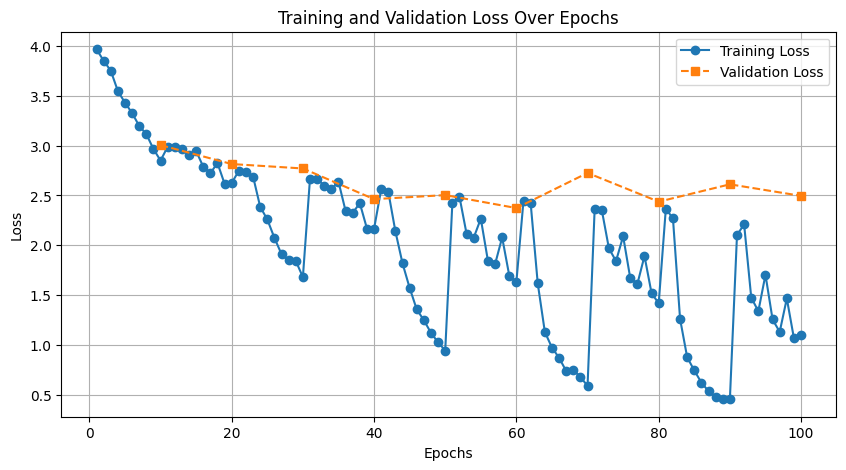

In [1]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open("checkpoints/tracker.json", "r") as f:
    tracker = json.load(f)

# Convert keys to integers and sort them
epochs = sorted(map(int, tracker.keys()))
losses = [tracker[str(epoch)]["Loss"] for epoch in epochs]
lrs = [tracker[str(epoch)]["lr"] for epoch in epochs]
val_losses = {epoch: tracker[str(epoch)]["Loss_val"] for epoch in epochs if "Loss_val" in tracker[str(epoch)]}

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label="Training Loss", marker="o", linestyle="-")

# Plot Validation Loss if available
if val_losses:
    plt.plot(val_losses.keys(), val_losses.values(), label="Validation Loss", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()